In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io.wavfile as sci_wav  # Open wav files
import os  # Manipulate files
# import warnings  # Warning removal
# warnings.filterwarnings('ignore')
from pickle import dump
from pickle import load
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout, Activation

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
ROOT_DIR = '/Users/DM/FS/mod4/proj4/audio-cats-and-dogs/cats_dogs/'
X_path = os.listdir(ROOT_DIR)
y = [0 if 'cat' in f else 1 for f in X_path]  # change y to int values

In [3]:
X_path[0:5]

['cat_74.wav',
 'dog_barking_63.wav',
 'cat_60.wav',
 'dog_barking_77.wav',
 'cat_48.wav']

In [4]:
y[0:5]

[0, 1, 0, 1, 0]

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X_path, y, test_size=0.25)

In [6]:
print("in X, there is {} cats and {} dogs".format(len(y) - sum(y), sum(y)))
print("in X_train, there is {} cats and {} dogs".format(len(y_train) - sum(y_train), sum(y_train)))
print("in X_val, there is {} cats and {} dogs".format(len(y_val) - sum(y_val), sum(y_val)))

in X, there is 164 cats and 113 dogs
in X_train, there is 115 cats and 92 dogs
in X_val, there is 49 cats and 21 dogs


In [7]:
def read_wav_files(wav_files):
    '''Returns a list of audio waves
    Params:
        wav_files: List of .wav paths
    
    Returns:
        List of audio signals
    '''
    if not isinstance(wav_files, list):
        wav_files = [wav_files]
    return [sci_wav.read(ROOT_DIR + f)[1] for f in wav_files]

print(read_wav_files('cat_1.wav'))
print(read_wav_files(['cat_1.wav', 'cat_2.wav']))

[array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16)]
[array([ 124,  107,    7, ..., -545, -494, -529], dtype=int16), array([-1028, -1039, -1064, ...,     6,    38,     2], dtype=int16)]


In [8]:
X_train, X_val = map(read_wav_files, [X_train, X_val])

In [9]:
X_train[0:5]

[array([  0,   0,   0, ..., -15, -38, -44], dtype=int16),
 array([ 70, 150,  71, ...,  66,  41,  29], dtype=int16),
 array([  0,  -1,   0, ..., 169, 185, 193], dtype=int16),
 array([  0,   0,   0, ...,  96,  93, 134], dtype=int16),
 array([ 51,  68,  44, ...,  97, 130, 127], dtype=int16)]

In [10]:
for x in X_train[0:5]:
    print(x.shape)

(14773,)
(71378,)
(57959,)
(17280,)
(54400,)


In [11]:
ys = y_train[0:4]

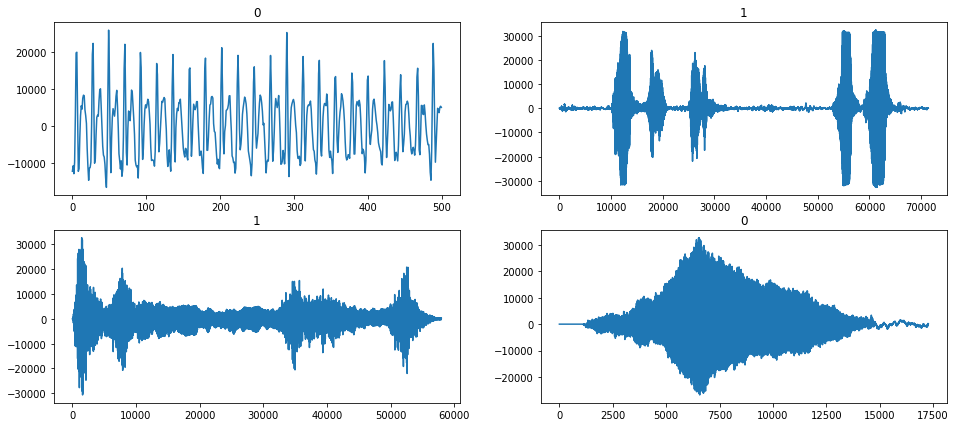

In [66]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(16,7))
axs[0][0].set_title(ys[0])
axs[0][0].plot(X_train[0][5000:5500])
axs[0][1].set_title(ys[1])
axs[0][1].plot(X_train[1])
axs[1][0].set_title(ys[2])
axs[1][0].plot(X_train[2])
axs[1][1].set_title(ys[3])
axs[1][1].plot(X_train[3])

In [13]:
max(X_train[1])

32390

In [14]:
X_train[5][0:50]

array([-109, -269, -352, -407, -415, -419, -433, -398, -367, -353, -305,
       -183,  -47,   51,  164,  264,  334,  346,  321,  269,  191,  118,
        115,  140,  152,  164,  170,  156,  117,   18,  -68,  -80, -107,
       -167, -204, -211, -174, -145, -171, -104,  -44,  -15,   44,  127,
        137,   94,   66,   -1,  -69, -141], dtype=int16)

In [15]:
min(X_train[1])

-32736

In [16]:
def get_long_vectors(X, y):
    # Create two long 1D arrays with all the audio waves concatenated one after the other
    # (one for the cats, the other for the dogs)
    X_cat = np.concatenate([_x for _x, _y in zip(X, y) if _y == 0])
    X_dog = np.concatenate([_x for _x, _y in zip(X, y) if _y == 1])
    # Apply normalization (zero mean, std = 1)
    X_cat = preprocessing.scale(X_cat)
    X_dog = preprocessing.scale(X_dog)
    return X_cat, X_dog

In [17]:
def get_next_nonsilence(_X, sample_len, idx):
    # get a random starting point in the big array of sound values of for the correct animal
    # but make sure it is not too close to the end to fit a whole observation.  This seems to be an 
    # augmentation strategy: since the observation starting points are random, there may be overlap
    # among observations, but this is good: with enough epochs we'll get a big sample of randomly
    # shifted 1-second segments.
    x_idx = np.random.randint(len(_X) - sample_len)
    # the following is to check whether the 1-second observation contains only low-level noise
    # (i.e. the dog or cat is not making sound during that second).  The model should be using these
    # in neither training nor validation sets.  Predicting "dog" or "cat" from a second of silence is
    # not what we want the model to do.
    silence = True
    while silence == True:
        if max(_X[x_idx : x_idx + sample_len]) > 0.4:
            silence = False
            return x_idx
        else:
            x_idx = np.random.randint(len(_X) - sample_len)

In [18]:
def cats_and_dogs_gen(X = X_train, y = y_train, n_samples=20, sample_len=16000):
# n_samples: amount of samples per batch
# sample_len: size of the samples in a batch
    while True:
    # making the loop infininte so that the generator just keeps making more batches (required for keras)
        X_cat, X_dog = get_long_vectors(X, y)
        # find the higher of (number of cats,  number of dogs) and divide that by the batch size to get number
        # of batches needed, then loop through this number, creating all the batches (or rather, yielding
        # them one at a time as a generator)
        for _ in range(int(max(sum(y), len(y) - sum(y)) / n_samples)):
            # set up each batch
            y_batch = np.zeros(n_samples)
            X_batch = np.zeros((n_samples, sample_len))
            # for each observation in batch
            for idx in range(n_samples):
                # alternate zeros and ones for the y value of the batch
                y_batch[idx] = idx % 2
                # assign a source of sound values depending on the target already set (0 or 1) for the current batch
                _X = X_cat if y_batch[idx] == 0 else X_dog
                x_idx = get_next_nonsilence(_X, sample_len, idx) 
                X_batch[idx] = _X[x_idx : x_idx + sample_len]
            yield (X_batch.reshape(n_samples, sample_len, 1),
                   y_batch.reshape(-1, 1) )

In [19]:
# x, y = next(cats_and_dogs_gen())

In [20]:
# x.shape

In [21]:
# plt.plot(x[11, : ,0])
# plt.show()

In [22]:
model = models.Sequential()
model.add(layers.Conv1D(padding = 'same', filters = 10, kernel_size = 3, strides = 2, input_shape = (16000, 1)))
model.add(layers.BatchNormalization())
model.add(Activation("relu"))
# model.add(Dropout(0.2))
for _ in range(9):
    model.add(layers.Conv1D(padding = 'same', filters = 10, kernel_size = 3, strides = 2))
    model.add(layers.BatchNormalization())
    model.add(Activation("relu"))
#     model.add(Dropout(0.2))
model.add(layers.GlobalAveragePooling1D())
# model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))

In [23]:
# model = load_model('audio12.h5')
# model.load_weights("audio3_best.hdf5")

In [24]:
model.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [25]:
filepath = "audio99_best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 8000, 10)          40        
_________________________________________________________________
batch_normalization_1 (Batch (None, 8000, 10)          40        
_________________________________________________________________
activation_1 (Activation)    (None, 8000, 10)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 10)          310       
_________________________________________________________________
batch_normalization_2 (Batch (None, 4000, 10)          40        
_________________________________________________________________
activation_2 (Activation)    (None, 4000, 10)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2000, 10)          310       
__________

In [27]:
history = model.fit_generator(
      cats_and_dogs_gen(),
      epochs = 15, steps_per_epoch = 100, validation_steps = 100,
      validation_data = cats_and_dogs_gen(X = X_val, y = y_val), callbacks = callbacks_list)

Epoch 1/15


/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


100/100 [==============================] - 117s 1s/step - loss: 0.7048 - acc: 0.5075 - val_loss: 0.6922 - val_acc: 0.5290

Epoch 00001: val_acc improved from -inf to 0.52900, saving model to audio99_best.hdf5
Epoch 2/15
100/100 [==============================] - 113s 1s/step - loss: 0.6570 - acc: 0.6140 - val_loss: 0.6732 - val_acc: 0.5960

Epoch 00002: val_acc improved from 0.52900 to 0.59600, saving model to audio99_best.hdf5
Epoch 3/15
100/100 [==============================] - 113s 1s/step - loss: 0.6170 - acc: 0.7390 - val_loss: 0.6403 - val_acc: 0.6920

Epoch 00003: val_acc improved from 0.59600 to 0.69200, saving model to audio99_best.hdf5
Epoch 4/15
100/100 [==============================] - 114s 1s/step - loss: 0.5426 - acc: 0.8055 - val_loss: 0.6159 - val_acc: 0.6825

Epoch 00004: val_acc did not improve from 0.69200
Epoch 5/15
100/100 [==============================] - 114s 1s/step - loss: 0.5086 - acc: 0.7840 - val_loss: 0.5648 - val_acc: 0.7345

Epoch 00005: val_acc improv

In [28]:
model.save('audio99.h5')

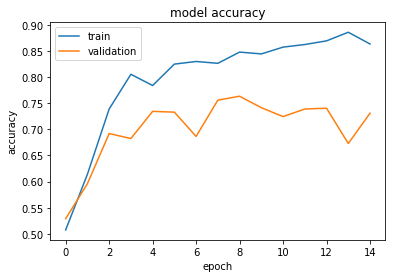

In [29]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [47]:
TEST_DIR = '/Users/DM/FS/mod4/proj4/audio-cats-and-dogs/test/'
test_path = os.listdir(TEST_DIR)
y_test = [0 if 'cat' in f else 1 for f in test_path]  # change y to int values

In [48]:
y_test

[1, 0, 0, 1, 1, 0, 0, 1, 0, 1]

In [49]:
test_path

['dog_barking_1.wav',
 'cat_164.wav',
 'cat_165.wav',
 'dog_barking_0.wav',
 'dog_barking_2.wav',
 'cat_167.wav',
 'cat_166.wav',
 'dog_barking_3.wav',
 'cat_163.wav',
 'dog_barking_4.wav']

In [50]:
X_test = list(map(read_wav_files, [test_path]))

In [51]:
X_test = X_test[0]

In [52]:
for x in X_test[0:5]:
    print(x.shape)

(185600,)
(163566,)
(182400,)
(275203,)
(190400,)


In [53]:
new_X_test = []
new_y_test = []
segments = []
running_sum = 0
segment_starts = []
for i in range(len(X_test)):
    x = preprocessing.scale(X_test[i])
    l = len(x)
    segs = l // 16000
    segments.append(segs)
    segment_starts.append(running_sum)
    running_sum += segs
    # ignores final second fraction
    for s in range(segs):
        new_X_test.append(x[s*16000:(s+1)*16000])
        new_y_test.append(y_test[i])
        

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


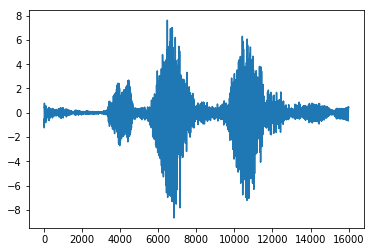

In [54]:
plt.plot(new_X_test[4])

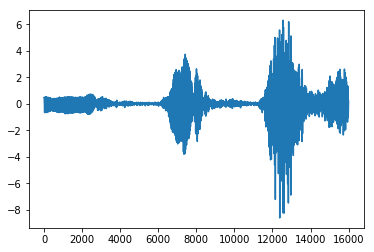

In [55]:
plt.plot(new_X_test[5])

In [56]:
len(new_y_test)

105

In [57]:
len(new_X_test)

105

In [58]:
reshaped_X_test = []
for x in new_X_test:
    q = x.reshape((16000,1))
    q = np.expand_dims(q, axis = 0)
    reshaped_X_test.append(q)

In [59]:
probas = []
for i in range(len(reshaped_X_test)):
    p = model.predict(reshaped_X_test[i])
    probas.append(p[0][0])

In [60]:
preds = []
for pr in probas:
    if pr > 0.5:
        preds.append(1)
    else:
        preds.append(0)

In [61]:
from sklearn.metrics import accuracy_score
ac = accuracy_score(new_y_test, preds)*100
print('final test accuracy: ', round(ac,1), '%') 

final test accuracy:  71.4 %


In [62]:
matches = []
over = []
for i in range(len(segment_starts)):
    m = np.mean(probas[segment_starts[i] : segment_starts[i] + segments[i]])
    if m > 0.5:
        o = 1
    else:
        o = 0
    over.append(o)
    if o == y_test[i]:
        matches.append(1)
    else:
        matches.append(0)

In [63]:
matches

[1, 1, 0, 1, 1, 0, 0, 1, 1, 1]

In [64]:
print('accuracy per audio clip:', round(100*sum(matches)/len(matches)), '%')

accuracy per audio clip: 70 %


In [65]:
over

[1, 0, 1, 1, 1, 1, 1, 1, 0, 1]